### Emma Klemets, 260775167   
All my work, code, output and written answers are in this notebook.

In [1]:
#for interactive plots
# %matplotlib ipympl

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Problem 1
As I warned in class, there are many, many deeply flawed pseudo-random number generators out there. One widely found version is the default random number generator in the C standard library. Look at test broken libc.py - this shows how to wrap the C standard library in python, call its random number generator, and save the output. (Note the numba wrapper is there for speed but is not required.) I’ve used it to generate random (x,y,z) positions with coordinates between 0 and 2^31 (the max random integer value in the standard library). The type of PRNG used in the library is notorious for introducing correlations between sequential points, with sets of points in n−dimensional space lying on a surprisingly small number of planes.

To make this effect easier to see, I’ve pulled out all the (x,y,z) triples
with 0 < x, y, z < 10^8 (so about 5% of the total span) and put them in the text file rand points.txt. Show that when correctly viewed, these triples lie along a set of planes (I get about 30) and so are very much not randomly distributed in 3D space. You can either do this by changing the view angle on a 3D plot, or plotting $(ax + by, z)$ for suitably chosen a and b. Do you see the same thing happen with python’s random number generator? If possible, can you see the same effect on your local machine? You may need to change the name of the library in the line: mylib=ctypes.cdll.LoadLibrary(“libc.dylib”)

where libc.so would be standard under a Linux system, and you can google for Windows. If you can’t get this part to work, that’s OK - just state so and you won’t lose points.

In [3]:
triples = np.transpose(np.loadtxt("rand_points.txt"))

In [ ]:
x = np.linspace(45, 60, 9)
a = 0
# b = 80

# add_subplot(nrows, ncols, index,
            
fig = plt.figure(figsize=(20,20))

# axs = ax.flatten()

for i, b in enumerate(x):
#     print(a)
    ax = fig.add_subplot(3, 3, i+1, projection='3d')
    ax.scatter(triples[0], triples[1], zs=triples[2])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_title("{}, {}".format(a, b))

    ax.view_init(a, b)
    
# plt.tight_layout()
plt.show()

In [ ]:
x = np.linspace(0, 1.0, 9)
b = 0.5

# add_subplot(nrows, ncols, index,
            
fig = plt.figure(figsize=(20,20))

# axs = ax.flatten()

for i, a in enumerate(x):
    print(a)
    ax = fig.add_subplot(3, 3, i+1,)
    ax.scatter(a*triples[0] +b*triples[1], triples[2])
    
#     ax.view_init(0, a) #what are the args here then?
#     ax.view_init(azim=0, elev=a)

fig.tight_layout()
plt.show()

In [7]:
# points = 
# figsize=(10,10)
fig = plt.figure()
ax = fig.add_subplot(111, projection=Axes3D.name)
ax.scatter(triples[0], triples[1], zs=triples[2], s=0.1)
ax.view_init(3, 87)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'z')

In [ ]:
"""
Now generating random integers from python's np.random.ranint 
in a similar fashion to previous ones from C.
This cell is pretty slow.
"""

n=300000000
# vec=get_randPy(n*3)

vec = np.random.randint(0, 2**31, n*3)
#vv=vec&(2**16-1)

vv=np.reshape(vec,[n,3])
# print(vv[0] < maxval)

vmax=np.max(vv,axis=1)

print(vmax)

In [ ]:
maxval=1e8

pythonTriples=np.transpose(vv[vmax<maxval,:])

# print(vv2)

In [ ]:
x = np.linspace(0, 170, 9)
a = 0
# b = 80

fig = plt.figure(figsize=(20,20))

for i, b in enumerate(x):
#     print(a)
    ax = fig.add_subplot(3, 3, i+1, projection='3d')
    ax.scatter(pythonTriples[0], pythonTriples[1], zs=pythonTriples[2])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_title("{}, {}".format(a, b))

    ax.view_init(a, b)
    
# plt.tight_layout()
plt.show()

In [ ]:
# libc.so on windows

"""
dir libc.so /s //finds nothing

"""

### Problem 2
We saw in class how to generate exponential deviates using a transformation. Now write a rejection method to generate exponential deviates from another distribution. Which of Lorentzians, Gaussians, and power laws could you use for the bounding distribution? You can assume the exponential deviates are non-negative (since you have to cut off the distribution somewhere, might as well be at zero). Show that a histogram of your deviates matches up with the expected exponential curve. How efficient can you make this generator, in terms of the fraction of uniform deviates that give rise to an exponential deviate?

what "generate exponential deviates using a transformation"? like the polar trick? yes


integrating from (0.001, inf)

$CDF(no) = 1000^a/(1000*a-1000)$ but wait this is a number - so i want the indef one? well that is fine

CDF: 
$y = x^{(1-a)}/(1-a)$

$CDF^{-1} = exp(ln(y(1-a))/(1-a))$

*Remember we had to put a lower cutoff in the power law to avoid exactly this sort of problem, so x could range from 1 to infinity.  You can pick the lower cutoff to be wherever you want, as long as it's greater than zero, though.  In your case, you want x+0.7 to start at zero, so if you introduce a new variable that's a shifted version of x, you should be able to get it to work.  Equivalently, you could set the minimum value in the power law integral to be something other than 1 (perhaps 0.7 in your case) and re-derive the transform.*

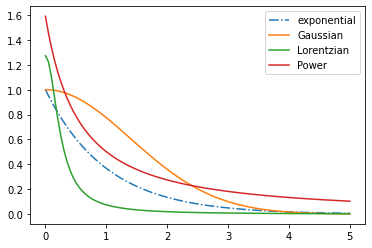

In [77]:
def gauss(x, sig):
    return np.exp(-(x)**2/(2*sig**2))

def lor(x, g):
    return 1/(np.pi) * (g/2)/(x**2 + (g/2)**2)

def power(x, a, b):
    return (x+b)**(-a)
    
x = np.linspace(0, 5, 100)
plt.plot(x, np.exp(-x), label="exponential", ls="-.")
plt.plot(x, gauss(x, 1.4), label="Gaussian")
plt.plot(x, lor(x, 0.5), label="Lorentzian")
plt.plot(x, power(x, 1.3, 0.7), label="Power")

plt.legend()
plt.show()

Hard to get the Lorentzian to be above the exponential, so I won't use that one. The power and gaussian both look ok, power is quite far away at low x, but a much better match for large x.

PDF $= (x+b)^{(-a)}$

CDF: 
$y = (x+b)^{1-a}/(1-a)$

$CDF^{-1} = exp(ln(y(1-a))/(1-a)) - b = (y(1-a))^{1/(1-a)} - b $

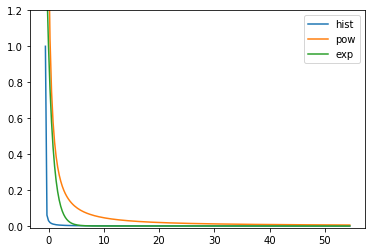

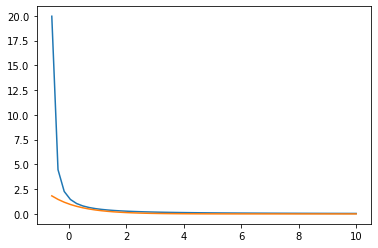

In [87]:
#what about: (x+0.7)^(-1.3) ? 

#but here the inverse 

# exponential should prob be -ve power or else it's crazy
# = exp(-x)

def power_dev(n):
#     y=np.random.uniform(1.1, 20, n)
    y=np.random.uniform(-20, -1, n)

    return (y*(1-alpha))**(1/(1-alpha)) - beta


def expo_from_pow(x):
    p = 1.0
    acc_prob = p * np.exp(-x)/(x+beta)**(-alpha)
    print(np.max(acc_prob)) #this needs to be < 1
    acc = np.random.rand(len(acc_prob))<acc_prob #gets values with prob of ratio
#     print(acc)
    return x[acc]
    
# alpha = 0.9
# beta = 0.6

alpha = 1.3
beta = 0.7

n=10000000
y=power_dev(n)

ys=y#[np.abs(y)<20]
a,b=np.histogram(ys, 200) #return values, bin edges
# print(b)

bs=0.5*(b[1:]+b[:-1]) #get centers of bins of hist

plt.plot(bs, a/a.max(), label="hist")

#not that close tho
plt.plot(bs, (bs+beta)**(-alpha), label="pow")
plt.plot(bs, np.exp(-bs), label="exp")
plt.legend()
plt.ylim(-0.01, 1.2)
plt.show()

xA = np.linspace(-0.6, 10)
plt.plot(xA, (xA+beta)**(-alpha))
plt.plot(xA, np.exp(-xA))

plt.show()

0.7718797879337673
Accept fract:  0.1056718


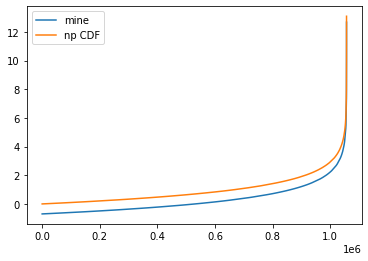

In [88]:
CDF = expo_from_pow(y)

print("Accept fract: ", len(CDF)/len(y)) #bad

CDF_np = np.random.exponential(1, len(CDF))

CDF.sort()
CDF_np.sort()

plt.plot(CDF, label="mine")
plt.plot(CDF_np, label="np CDF")
plt.legend()

plt.show()

### Problem 3
Repeat problem 2, but now use a ratio-of-uniforms generator. If u goes from 0 to 1, what are your limits on v? How efficient is this generator, in terms of number of exponential deviates produced per uniform deviate? Make sure to plot the histogram again and show it still produces the correct answer.

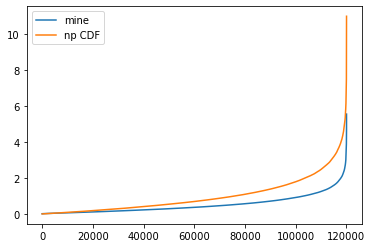

In [108]:
n=10000000
u=np.random.rand(n) #0-1
v=20*np.random.rand(n)+.01 #what should this actually be?
"""
>0 ?

"""

ratio = v/u
acc = u < np.exp(-ratio)
accepVals = ratio[acc]

CDF_np = np.random.exponential(1, len(accepVals))

accepVals.sort()
CDF_np.sort()

plt.plot(accepVals, label="mine")
plt.plot(CDF_np, label="np CDF")
plt.legend()

plt.show()

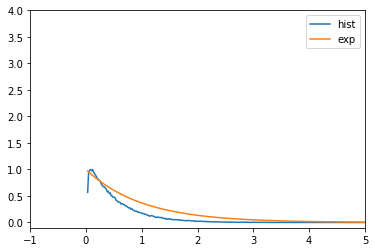

In [106]:
a,b=np.histogram(accepVals, 300) #return values, bin edges
# print(b)

bs=0.5*(b[1:]+b[:-1]) #get centers of bins of hist

plt.plot(bs, a/a.max(), label="hist")

#not that close tho
# plt.plot(bs, (bs+beta)**(-alpha), label="pow")
plt.plot(bs, np.exp(-bs), label="exp")
plt.legend()
plt.ylim(-0.1, 4)
plt.xlim(-1, 5)

plt.show()